# PCL Experiment Notebook

Train algorithms on increasing dataset sizes and plot risk/likelihood.

## Setup

Environment, imports, device selection, and reproducibility seeds.

In [1]:
# Imports and path setup
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Add project root to path if needed (before importing project modules)
sys.path.append(str(Path('..').resolve()))

from source.dataset import datasets
from source.learning import algorithms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
from source.utils import hparams_registry
from source.utils.eval_helper import eval_metrics

# Select device: use GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Reproducibility
seed = int(os.environ.get('SEED', 0))
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(seed)
print(f'Using seed: {seed}')

# Utility functions for robust error handling
import logging
# Configure logging for better error tracking

# Import utility functions from misc.py
from source.utils.misc import print_error_summary, group_counts, build_group_index, w, safe_mean, safe_extract_loss, InfiniteDataLoader, load_pretrained_featurizer, find_timestamp_root
print("Utility functions for robust error handling loaded successfully.")

/home/mila/t/tom.marty/invariant_bench/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Using seed: 0
Utility functions for robust error handling loaded successfully.


## Experiment configuration

Dataset choice, learners, and result containers.

In [ ]:
DEBUG = False

# Experiment config
DATASET_NAME = 'CMNIST'
DATA_PATH = os.path.expanduser('~/scratch/invariant_bench/data/benchmark')
LEARNERS =  ['GroupDRO', 'ERM'] # ['GroupDRO','ERM', 'DFR', 'IRM','ReSample']  # invariant learners to compare
NETWORK_NAME = 'CNN'  # éither 'MLP' or pre-trained 'ResNet'
BATCH_SIZE = 128
NUM_FIT = 7 # number of points in the PCL curve
NUM_WORKERS = 0

USE_STRATIFIED = True # Toggle: use stratified (label, attr) sampling such that the class ratio is preserved
ROBUST_TRAINING = True  # Enable robust error handling
MAX_RETRIES = 3  # Maximum number of retries for failed operations
CONTINUE_ON_ERROR = True  # Continue with next algorithm/size if current fails
SAVE_PARTIAL_RESULTS = True  # Save results even if some experiments fail

# Early stopping configuration
ES_MIN_DELTA = 0.0       # minimum improvement to reset 
ES_PATIENCE = 3         # checkpoints without improvement before stopping
if DEBUG:
    ES_PATIENCE = 0
    LEARNERS = ['ERM']  # only run ERM in debug mode

# featurizer loading
LOAD_PRETRAINED = os.environ.get('LOAD_PRETRAINED', 'False').lower() == 'true'
PRETRAINED_DIR = 'checkpoints'  # Will be updated to use shared result directory in training section

print('Config:')
print(f'  Dataset: {DATASET_NAME}')
print(f'  Learners: {LEARNERS}')
print(f'  Data path: {DATA_PATH}')
print(f'  Stratified sampling: {USE_STRATIFIED}')
print(f'  Debug mode: {DEBUG}')
print(f'  Load pretrained: {LOAD_PRETRAINED}')
if LOAD_PRETRAINED:
    print(f'  Pretrained dir: {PRETRAINED_DIR} (will be updated to use shared result folder)')

# Prepare per-learner results storage
val_loss_map = {alg: [] for alg in LEARNERS}           # validation loss means (best)
train_loss_map = {alg: [] for alg in LEARNERS}        # training loss mean (per size)
test_loss_map  = {alg: [] for alg in LEARNERS}        # test loss means (final model)
test_acc_map = {alg: [] for alg in LEARNERS}          # test accuracy
worst_group_acc_map = {alg: [] for alg in LEARNERS}   # test worst-group accuracy
group_acc_map = {alg: [] for alg in LEARNERS}         # all group accuracies per algorithm and size

## Hyperparameters

Defaults and dataset-specific overrides.

In [3]:
# Hyperparameters template
import os
from source.utils.misc import safe_float_env

# We'll derive specific hparams per learner in the training loop
base_hparams = hparams_registry.default_hparams('ERM', DATASET_NAME)
if NETWORK_NAME == 'ResNet':
    base_hparams.update({
        'image_arch': 'resnet_sup_in1k',
        'pretrained': True,
        'input_size': 224
    })
elif NETWORK_NAME == 'MLP':
    base_hparams.update({
        'image_arch': 'simple_mlp',
        'input_size': 28,
        'lr': 1e-3,
    })
elif NETWORK_NAME == 'CNN':
    base_hparams.update({
        'image_arch': 'mnist_cnn',
        'input_size': 28,
        'lr': 1e-3,
    })


"""
Colored MNIST specific hyperparameters:
- cmnist_label_prob: Probability of label imbalance (default 0.5)
- cmnist_attr_prob: Probability of attribute imbalance (default 0.5)
- cmnist_spur_prob: Controls the summed diagonal proportion (0,1). The more this is towards 0, the more the color is spuriously correlated with the label. 

"""

cminist_label_prob = safe_float_env("CMNIST_LABEL_PROB", 0.5)
cmnist_attr_prob = safe_float_env("CMNIST_ATTR_PROB", 0.5)

cmnist_spur_prob = safe_float_env("CMNIST_SPUR_PROB", 0.1)

if DATASET_NAME == 'CMNIST':
    base_hparams.update({
        'cmnist_label_prob': cminist_label_prob,
        'cmnist_attr_prob': cmnist_attr_prob, 
        'cmnist_spur_prob': cmnist_spur_prob,
        'cmnist_flip_prob': 0.0,
    })



## Datasets

Load train/val/test splits and preview samples.

In [4]:
# Attach key attributes to Subset objects for easier access
def attach_dataset_attributes(subset):
    """ Attach key attributes from the underlying dataset to a Subset object."""
    if hasattr(subset, 'dataset'):
        for attr in ['INPUT_SHAPE', 'num_labels', 'num_attributes', 'data_type']:
            if hasattr(subset.dataset, attr):
                setattr(subset, attr, getattr(subset.dataset, attr))

# Datasets

# Create a perfectly balanced test dataset (all probabilities set to 0.5)
balanced_test_hparams = base_hparams.copy()
balanced_test_hparams.update({
    'cmnist_label_prob': 0.5,
    'cmnist_attr_prob': 0.5,
    'cmnist_spur_prob': 0.5,
    'cmnist_flip_prob': 0.0
})

DatasetClass = getattr(datasets, DATASET_NAME)
train_dataset = DatasetClass(DATA_PATH, 'tr', base_hparams)
val_dataset = DatasetClass(DATA_PATH, 'va', base_hparams)
test_dataset = DatasetClass(DATA_PATH, 'te', balanced_test_hparams)

# If debug, reduce all datasets to size 100
if DEBUG:
    train_indices = random.sample(range(len(train_dataset)), min(100, len(train_dataset)))
    val_indices = random.sample(range(len(val_dataset)), min(100, len(val_dataset)))
    test_indices = random.sample(range(len(test_dataset)), min(100, len(test_dataset)))
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)
    test_dataset = Subset(test_dataset, test_indices)
    dataset_sizes = [10, 100]
else:
    max_train_size = len(train_dataset)
    dataset_sizes = np.logspace(1, np.log10(max_train_size), num=NUM_FIT, dtype=int).tolist()

attach_dataset_attributes(train_dataset)
attach_dataset_attributes(val_dataset)
attach_dataset_attributes(test_dataset)

indices = list(range(len(train_dataset)))
random.shuffle(indices)

input_shape = train_dataset.INPUT_SHAPE
num_labels = train_dataset.num_labels
num_attributes = train_dataset.num_attributes
data_type = getattr(train_dataset, 'data_type', 'images')

print('Datasets:')
print(f'  Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)} (restricted)')
print(f'  Input shape: {input_shape} | data_type: {data_type}')
print(f'  num_labels: {num_labels} | num_attributes: {num_attributes}')

    
if USE_STRATIFIED:
    group_to_indices = build_group_index(train_dataset)
    group_counts_dict = {k: len(v) for k, v in sorted(group_to_indices.items())}
    print('Stratified groups (counts):', group_counts_dict)

    # Aggregate counts for each class and attribute
    import pandas as pd
    import numpy as np
    df = pd.DataFrame([{'class': k[0], 'attribute': k[1], 'count': v} for k, v in group_counts_dict.items()])
    class_counts = df.groupby('class')['count'].sum()
    attr_counts = df.groupby('attribute')['count'].sum()
    total = df['count'].sum()

    print('\nClass distribution:')
    class_dist = df.groupby('class')['count'].sum().to_frame()
    class_dist['percentage'] = (class_dist['count'] / total * 100).round(2)
    print(class_dist.to_string())

    print('\nAttribute distribution:')
    attr_dist = df.groupby('attribute')['count'].sum().to_frame()
    attr_dist['percentage'] = (attr_dist['count'] / total * 100).round(2)
    print(attr_dist.to_string())

    print('\nGroup (class, attribute) distribution:')
    group_dist = df.set_index(['class','attribute'])
    group_dist['percentage'] = (group_dist['count'] / total * 100).round(2)
    print(group_dist.to_string())
    
# Preview a few samples (images only)
if data_type == 'images':
    fig, axes = plt.subplots(5, 5, figsize=(8, 8))
    axes = axes.flatten()

    for k, ax in enumerate(axes):
        idx, x, y, a, _ = train_dataset[k]
        # Scale per-image to [0,1] for visualization
        x_vis = x.detach().cpu()
        x_min, x_max = x_vis.min(), x_vis.max()
        x_vis = (x_vis - x_min) / (x_max - x_min + 1e-6)
        ax.imshow(x_vis.permute(1, 2, 0))
        ax.set_title(f'Label: {int(y)}, Attr: {int(a)}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('Non-image dataset preview omitted.')

Datasets:
  Train size: 30000 | Val size: 10000 | Test size: 20000 (restricted)
  Input shape: (3, 28, 28) | data_type: images
  num_labels: 2 | num_attributes: 2


KeyboardInterrupt: 

### Dataset Analysis

If `USE_STRATIFIED` is True, each training subset for a given size is drawn approximately proportional to the (label, attr) group counts in the full training set using the helper `w(...)`. This helps maintain group balance across different subset sizes. Set `USE_STRATIFIED = False` to revert to the earlier simple prefix-based random subset selection.


In [ ]:
# Run group coverage checks
_ = group_counts(train_dataset, 'train')
_ = group_counts(val_dataset, 'val')
_ = group_counts(test_dataset, 'test')

group_to_indices = build_group_index(train_dataset)

[train] Could not read item 0: too many values to unpack (expected 4)
[train] size=30000 | unique attrs=[] | unique labels=[]
[train] attr counts: {}
[train] label counts: {}
[train] (label, attr) counts: {}
[val] Could not read item 0: too many values to unpack (expected 4)
[val] size=10000 | unique attrs=[] | unique labels=[]
[val] attr counts: {}
[val] label counts: {}
[val] (label, attr) counts: {}
[test] Could not read item 0: too many values to unpack (expected 4)
[test] size=20000 | unique attrs=[] | unique labels=[]
[test] attr counts: {}
[test] label counts: {}
[test] (label, attr) counts: {}


## Training and evaluation

Main training loop over dataset sizes and algorithms with robust error handling.

In [ ]:
import os
import math
import time
import itertools

# Use environment variable for timestamp if set, else fallback to current time
base_timestamp = os.environ.get('RESULT_FOLDER', time.strftime('%Y%m%d-%H%M%S'))

result_dir = os.path.join("../results", base_timestamp)
os.makedirs(result_dir, exist_ok=True)


log_file = os.path.join(result_dir, 'training.log')
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Enhanced error tracking
ERROR_LOG = {
    'algorithm_failures': {},
    'size_failures': {},
    'step_failures': {},
    'validation_failures': {},
    'test_failures': {}
}

# Precompute subsets for each dataset size so all learners use the same indices
subset_indices_map = {}
for size in dataset_sizes:
    if USE_STRATIFIED:
        # Draw indices proportionally to group distribution
        subset_indices = w(group_to_indices, size, rng=np.random.RandomState(0 + size))
        subset_indices_map[size] = subset_indices
    else:
        # Simple random prefix
        subset_indices_map[size] = indices[:size]
# Initialize result maps with NaNs
for alg in LEARNERS:
    val_loss_map[alg] = [float('nan')] * len(dataset_sizes)
    train_loss_map[alg] = [float('nan')] * len(dataset_sizes)
    test_loss_map[alg] = [float('nan')] * len(dataset_sizes)
    test_acc_map[alg] = [float('nan')] * len(dataset_sizes)
    worst_group_acc_map[alg] = [float('nan')] * len(dataset_sizes)
    group_acc_map[alg] = [{} for _ in dataset_sizes]

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# === Main Experiment Loop ===
for size in dataset_sizes:
    print(f"\n--- Training with size={size} ---")
    subset_indices = subset_indices_map[size]
    train_subset = Subset(train_dataset, subset_indices)

    # Attach attributes to subset for convenience
    attach_dataset_attributes(train_subset)

    input_shape = train_subset.INPUT_SHAPE
    num_labels = train_subset.num_labels
    num_attributes = train_subset.num_attributes
    data_type = getattr(train_subset, 'data_type', 'images')

    for ALGO_NAME in LEARNERS:
        try:
            print(f"\n=== Learner: {ALGO_NAME} ===")
            
            # --- Setup hyperparameters for current algorithm ---
            hparams = hparams_registry.default_hparams(ALGO_NAME, DATASET_NAME)
            hparams.update(base_hparams)

            # --- Initialize Algorithm ---
            AlgorithmClass = algorithms.get_algorithm_class(ALGO_NAME)
            algo = AlgorithmClass(data_type, input_shape, num_labels, num_attributes, len(train_subset), hparams)
            if hasattr(algo, 'to'):
                algo = algo.to(DEVICE)

            # --- Load pretrained featurizer if enabled ---
            if LOAD_PRETRAINED:
                load_pretrained_featurizer(algo, size, cmnist_spur_prob, PRETRAINED_DIR, DEVICE)


            print(f"[Init] size={size} | algo={ALGO_NAME} | data_type={data_type} | input_shape={input_shape} | labels={num_labels} | attrs={num_attributes} | stratified={USE_STRATIFIED}")

            # --- Training loop with early stopping ---
            checkpoint_freq = max(20, math.ceil(len(train_subset) / BATCH_SIZE)) # process at least 20 batches at minimum between evaluations
            best_val = float('inf')
            bad_checks = 0

            ckpt_dir = os.path.join(result_dir, 'checkpoints', ALGO_NAME)
            os.makedirs(ckpt_dir, exist_ok=True)
            best_model_path = os.path.join(ckpt_dir, f'best_model_{ALGO_NAME}_size{size}.pt')

            train_losses_epoch = []
            algo.train()

            if hparams['group_balanced']:
                # if attribute not available, groups degenerate to classes
                train_weights = np.asarray([train_dataset.weights_g[idx] for idx in subset_indices])
                train_weights /= np.sum(train_weights)
            else:
                train_weights = None

            train_minibatches_iterator = iter(InfiniteDataLoader(
            dataset=train_subset,
            weights=train_weights,
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            seed=seed))

            pbar = tqdm(itertools.count(), desc=f"Train size={size} ({ALGO_NAME})", leave=False)

            for step in pbar:
                try:
                    # --- Training step ---
                    i, x, y, a,_ = next(train_minibatches_iterator)
                    x, y, a = x.to(DEVICE), y.to(DEVICE), a.to(DEVICE)

                    # Robust training step with error handling
                    try:
                        loss_dict = algo.update((i, x, y, a), step)
                        cur_loss = safe_extract_loss(loss_dict)
                        train_losses_epoch.append(cur_loss)
                    except Exception as e:
                        logger.warning(f"[Warning] Training step {step} failed: {e}")
                        cur_loss = float('nan')
                        train_losses_epoch.append(cur_loss)

                    # --- Validation checkpoint (once per epoch) ---
                    do_check = ((step + 1) % checkpoint_freq == 0)
                    if do_check:
                        try:
                            algo.eval()
                            val_losses_step = []
                            val_acc_step = []

                            with torch.no_grad():
                                for i_val, x_val, y_val, a_val, _ in val_loader:
                                    try:
                                        x_val, y_val, a_val = x_val.to(DEVICE), y_val.to(DEVICE), a_val.to(DEVICE)
                                        y_pred, vloss = algo.predict(x_val, y_val, return_loss=True)

                                        vloss_safe = safe_extract_loss(vloss)
                                        val_losses_step.append(vloss_safe)

                                        try:
                                            if hasattr(algo, 'predict_labels'):
                                                y_hat = algo.predict_labels(x_val)
                                            else:
                                                y_hat = y_pred.argmax(dim=-1) if y_pred.ndim > 1 else (y_pred > 0.5).long()
                                            acc = float((y_hat == y_val).float().mean().item())
                                            val_acc_step.append(acc)
                                        except Exception as e:
                                            logger.warning(f"[Warning] Accuracy computation failed: {e}")
                                            val_acc_step.append(float('nan'))
                                    except Exception as e:
                                        logger.warning(f"[Warning] Validation batch failed: {e}")
                                        val_losses_step.append(float('nan'))
                                        val_acc_step.append(float('nan'))

                            mean_val_loss = safe_mean(val_losses_step)
                            mean_val_acc = safe_mean(val_acc_step)

                            if np.isfinite(mean_val_loss) and np.isfinite(best_val):
                                improved = (best_val - mean_val_loss) > ES_MIN_DELTA
                                if improved:
                                    best_val = mean_val_loss
                                    bad_checks = 0
                                    try:
                                        torch.save(algo.state_dict(), best_model_path)
                                    except Exception as e:
                                        logger.warning(f"[Warning] Failed to save checkpoint: {e}")
                                else:
                                    bad_checks += 1
                            elif np.isfinite(mean_val_loss):
                                best_val = mean_val_loss
                                bad_checks = 0
                                try:
                                    torch.save(algo.state_dict(), best_model_path)
                                except Exception as e:
                                    logger.warning(f"[Warning] Failed to save checkpoint: {e}")

                            # Print progress info instead of using progress bar
                            pbar.set_postfix({
                                'train_loss': cur_loss if np.isfinite(cur_loss) else 'NaN',
                                'val_loss': mean_val_loss if np.isfinite(mean_val_loss) else 'NaN',
                                'val_acc': mean_val_acc if np.isfinite(mean_val_acc) else 'NaN',
                                'best_val': best_val if np.isfinite(best_val) else 'NaN',
                                'pat': f"{bad_checks}/{ES_PATIENCE}"
                            })
                            
                            if bad_checks >= ES_PATIENCE:
                                print(f"[EarlyStop] size={size} | algo={ALGO_NAME} | step={step+1} | best_val={best_val:.4f}")
                                break
                        except Exception as e:
                            logger.warning(f"[Warning] Validation checkpoint failed at step {step}: {e}")
                        finally:
                            algo.train()  # Ensure we're back in training mode

                except Exception as e:
                    logger.warning(f"[Warning] Step {step} failed entirely: {e}")
                    continue

            # Close the progress bar when training finishes
            pbar.close()

            val_loss_map[ALGO_NAME][dataset_sizes.index(size)] = best_val if np.isfinite(best_val) else float('nan')
            train_loss_map[ALGO_NAME][dataset_sizes.index(size)] = safe_mean(train_losses_epoch)

            try:
                if os.path.exists(best_model_path):
                    algo.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
                    print(f"[Info] Loaded best model from {best_model_path}")
                else:
                    print(f"[Warning] No checkpoint found at {best_model_path}, using current model")
            except Exception as e:
                logger.warning(f"[Warning] Failed to load checkpoint: {e}")

            try:
                #TODO eval should be on WGA ? 
                algo.eval()
                metrics = eval_metrics(algo, test_loader, DEVICE)

                test_bce = float('nan')
                test_acc = float('nan')
                worst_group_acc = float('nan')
                group_accuracies = {}

                if isinstance(metrics, dict):
                    overall_metrics = metrics.get('overall', {})
                    if isinstance(overall_metrics, dict):
                        test_bce = overall_metrics.get('BCE', float('nan'))
                        test_acc = overall_metrics.get('accuracy', float('nan'))

                    min_group_metrics = metrics.get('min_group', {})
                    if isinstance(min_group_metrics, dict):
                        worst_group_acc = min_group_metrics.get('accuracy', float('nan'))
                    
                    # Extract all group accuracies
                    group_metrics = metrics.get('per_group', {})
                    if isinstance(group_metrics, dict):
                        for group_key, group_data in group_metrics.items():
                            if isinstance(group_data, dict) and 'accuracy' in group_data:
                                group_accuracies[f'group_{group_key}_acc'] = group_data['accuracy']

                test_loss_map[ALGO_NAME][dataset_sizes.index(size)] = test_bce
                test_acc_map[ALGO_NAME][dataset_sizes.index(size)] = test_acc
                worst_group_acc_map[ALGO_NAME][dataset_sizes.index(size)] = worst_group_acc
                group_acc_map[ALGO_NAME][dataset_sizes.index(size)] = group_accuracies

                print(f"[Test Results] | test_acc={test_acc:.4f} | worst_group_acc={worst_group_acc:.4f} | test_bce={test_bce:.4f}")
                if group_accuracies:
                    group_acc_str = " | ".join([f"{k}={v:.4f}" for k, v in group_accuracies.items()])
                    print(f"[Group Results] | {group_acc_str}")
            
            except Exception as e:
                logger.warning(f"[Warning] Test evaluation failed for {ALGO_NAME} size={size}: {e}")
        
        except Exception as e:
            logger.error(f"[Error] Training failed for {ALGO_NAME} size={size}: {e}")

print("\n=== Training Complete ===")


--- Training with size=10 ---

=== Learner: GroupDRO ===
[Init] size=10 | algo=GroupDRO | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True


Train size=10 (GroupDRO): 0it [00:00, ?it/s]

[EarlyStop] size=10 | algo=GroupDRO | step=140 | best_val=0.3701
[Info] Loaded best model from ../results/20250922-161528/checkpoints/GroupDRO/best_model_GroupDRO_size10.pt
[Test Results] | test_acc=0.5080 | worst_group_acc=0.0000 | test_bce=1.4031
[Group Results] | group_y=0,a=0_acc=1.0000 | group_y=0,a=1_acc=0.0486 | group_y=1,a=0_acc=0.0000 | group_y=1,a=1_acc=0.9799

=== Learner: ERM ===
[Init] size=10 | algo=ERM | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True


[EarlyStop] size=10 | algo=ERM | step=100 | best_val=0.3477
[Info] Loaded best model from ../results/20250922-161528/checkpoints/ERM/best_model_ERM_size10.pt
[Test Results] | test_acc=0.5004 | worst_group_acc=0.0000 | test_bce=1.2869
[Group Results] | group_y=0,a=0_acc=1.0000 | group_y=0,a=1_acc=0.0000 | group_y=1,a=0_acc=0.0000 | group_y=1,a=1_acc=1.0000

--- Training with size=37 ---

=== Learner: GroupDRO ===
[Init] size=37 | algo=GroupDRO | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True


[EarlyStop] size=37 | algo=GroupDRO | step=180 | best_val=0.4387
[Info] Loaded best model from ../results/20250922-161528/checkpoints/GroupDRO/best_model_GroupDRO_size37.pt
[Test Results] | test_acc=0.5201 | worst_group_acc=0.1208 | test_bce=1.1229
[Group Results] | group_y=0,a=0_acc=0.8988 | group_y=0,a=1_acc=0.1288 | group_y=1,a=0_acc=0.1208 | group_y=1,a=1_acc=0.9303

=== Learner: ERM ===
[Init] size=37 | algo=ERM | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True


[EarlyStop] size=37 | algo=ERM | step=120 | best_val=0.3290
[Info] Loaded best model from ../results/20250922-161528/checkpoints/ERM/best_model_ERM_size37.pt
[Test Results] | test_acc=0.5004 | worst_group_acc=0.0000 | test_bce=1.2152
[Group Results] | group_y=0,a=0_acc=0.9998 | group_y=0,a=1_acc=0.0000 | group_y=1,a=0_acc=0.0000 | group_y=1,a=1_acc=1.0000

--- Training with size=144 ---

=== Learner: GroupDRO ===
[Init] size=144 | algo=GroupDRO | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True


[EarlyStop] size=144 | algo=GroupDRO | step=180 | best_val=0.5104
[Info] Loaded best model from ../results/20250922-161528/checkpoints/GroupDRO/best_model_GroupDRO_size144.pt
[Test Results] | test_acc=0.5059 | worst_group_acc=0.0317 | test_bce=0.7199
[Group Results] | group_y=0,a=0_acc=0.8858 | group_y=0,a=1_acc=0.0317 | group_y=1,a=0_acc=0.1160 | group_y=1,a=1_acc=0.9914

=== Learner: ERM ===
[Init] size=144 | algo=ERM | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True


[EarlyStop] size=144 | algo=ERM | step=220 | best_val=0.3217
[Info] Loaded best model from ../results/20250922-161528/checkpoints/ERM/best_model_ERM_size144.pt
[Test Results] | test_acc=0.5004 | worst_group_acc=0.0000 | test_bce=1.2455
[Group Results] | group_y=0,a=0_acc=1.0000 | group_y=0,a=1_acc=0.0000 | group_y=1,a=0_acc=0.0000 | group_y=1,a=1_acc=1.0000

--- Training with size=547 ---

=== Learner: GroupDRO ===
[Init] size=547 | algo=GroupDRO | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True


[EarlyStop] size=547 | algo=GroupDRO | step=80 | best_val=0.6514
[Info] Loaded best model from ../results/20250922-161528/checkpoints/GroupDRO/best_model_GroupDRO_size547.pt
[Test Results] | test_acc=0.5008 | worst_group_acc=0.0004 | test_bce=0.6927
[Group Results] | group_y=0,a=0_acc=0.9996 | group_y=0,a=1_acc=0.0012 | group_y=1,a=0_acc=0.0004 | group_y=1,a=1_acc=1.0000

=== Learner: ERM ===
[Init] size=547 | algo=ERM | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True


KeyboardInterrupt: 

## Results and plots

Validation CE and training loss across learners and dataset sizes.

/tmp/ipykernel_2758165/409942170.py:101: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax3.plot(x_vals, y_vals, '-o', label=f'{alg} Test Acc', color=alg_colors[alg], linestyle='-')
/tmp/ipykernel_2758165/409942170.py:109: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--s" (-> linestyle='--'). The keyword argument will take precedence.
  ax3.plot(x_vals, y_vals, '--s', label=f'{alg} Worst Group Acc', color=alg_colors[alg], linestyle='--')


[savefig] Saved figure to ../results/20250922-140111/plots/cmnist_summary_metrics_0.5_spur0.9.png
[Info] Plot saved successfully: ../results/20250922-140111/plots/cmnist_summary_metrics_0.5_spur0.9.png


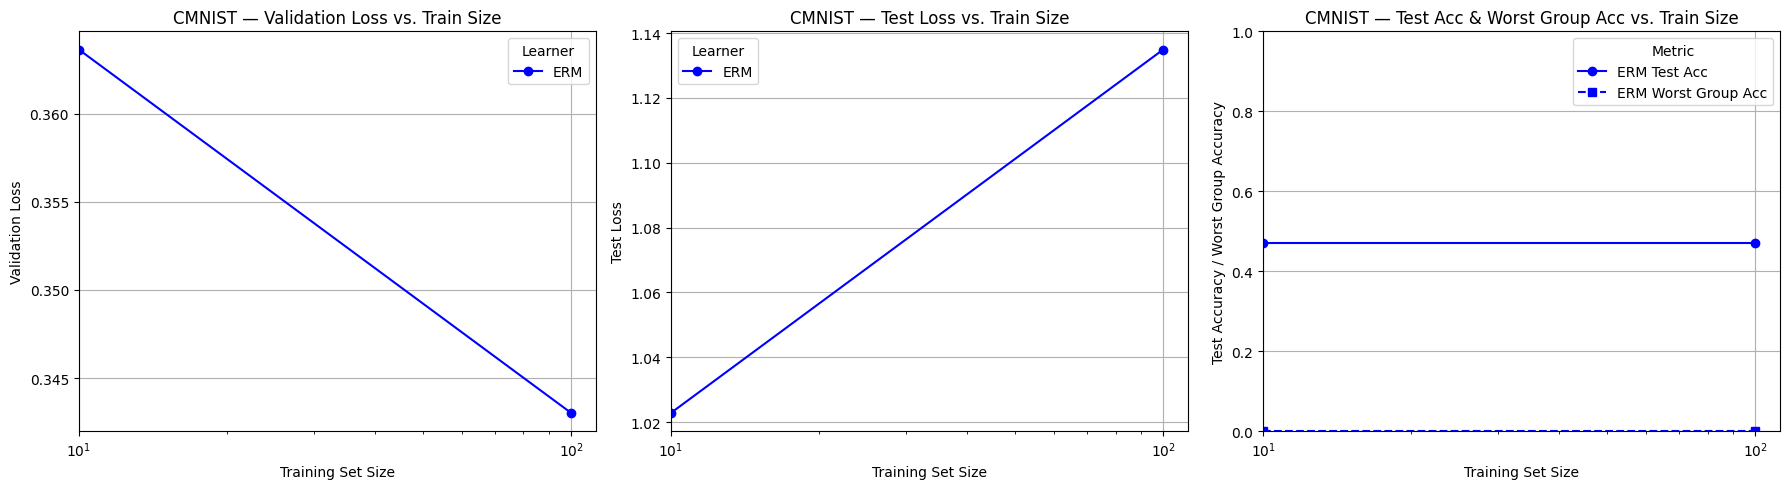

Added 4 group accuracy columns: ['group_y=0,a=0_acc', 'group_y=0,a=1_acc', 'group_y=1,a=0_acc', 'group_y=1,a=1_acc']
PCL curve results saved to ../results/20250922-140111/pcl_curve_seed0_attr0p5_spur0p9.csv
PCL curve results also saved to ../results/20250922-140111/data/pcl_curve_seed0_attr0p5_spur0p9.csv
CSV contains 15 columns and 2 rows

=== Results Summary for CMNIST ===

ERM:
  Valid validation losses: 2/2
  Valid test accuracies: 2/2
  Valid worst group accuracies: 2/2
  Best test accuracy: 0.4700
  Best worst group accuracy: 0.0000
  Group accuracies tracked: ['group_y=0,a=0_acc', 'group_y=0,a=1_acc', 'group_y=1,a=0_acc', 'group_y=1,a=1_acc']


In [ ]:
# Plotting and CSV export
import pandas as pd
from source.utils.plotting import savefig

# Robustly parse group accuracy data and generate CSV records
pcl_records = []

for alg in LEARNERS:
    for i, size in enumerate(dataset_sizes):
        record = {
            'algorithm': alg,
            'dataset_size': size,
            'val_loss': val_loss_map.get(alg, [float('nan')] * len(dataset_sizes))[i],
            'train_loss': train_loss_map.get(alg, [float('nan')] * len(dataset_sizes))[i], 
            'test_loss': test_loss_map.get(alg, [float('nan')] * len(dataset_sizes))[i],
            'test_acc': test_acc_map.get(alg, [float('nan')] * len(dataset_sizes))[i],
            'worst_group_acc': worst_group_acc_map.get(alg, [float('nan')] * len(dataset_sizes))[i],
            'seed': seed,
            'cmnist_attr_prob': base_hparams.get('cmnist_attr_prob'),
            'cmnist_spur_prob': base_hparams.get('cmnist_spur_prob'),
            'load_pretrained': LOAD_PRETRAINED
        }
        
        # Add all group accuracies to the record
        if alg in group_acc_map and i < len(group_acc_map[alg]):
            group_accs = group_acc_map[alg][i]
            if isinstance(group_accs, dict):
                record.update(group_accs)
            
        pcl_records.append(record)

def filter_finite_values(x_vals, y_vals):
    """Remove NaN/inf values from plotting data"""
    try:
        finite_mask = np.isfinite(y_vals)
        return np.array(x_vals)[finite_mask], np.array(y_vals)[finite_mask]
    except Exception as e:
        print(f"[Warning] Error filtering values: {e}")
        return np.array([]), np.array([])

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Algorithm colors for consistent plotting
alg_colors = {
    'ERM': 'blue',
    'IRM': 'red', 
    'GroupDRO': 'green',
}

# Validation loss
ax = axes[0]
for alg in LEARNERS:
    try:
        if alg in val_loss_map and val_loss_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, val_loss_map[alg])
            if len(x_vals) > 0:
                ax.plot(x_vals, y_vals, '-o', label=alg, color=alg_colors.get(alg, 'black'))
            else:
                print(f"[Warning] No valid validation loss data for {alg}")
    except Exception as e:
        print(f"[Warning] Failed to plot validation loss for {alg}: {e}")

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_xlim(left=min(dataset_sizes))
ax.set_title(f'{DATASET_NAME} — Validation Loss vs. Train Size')
ax.grid(True)
ax.legend(title='Learner')

# Test loss
ax2 = axes[1]
for alg in LEARNERS:
    try:
        if alg in test_loss_map and test_loss_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, test_loss_map[alg])
            if len(x_vals) > 0:
                ax2.plot(x_vals, y_vals, '-o', label=alg, color=alg_colors.get(alg, 'black'))
            else:
                print(f"[Warning] No valid test loss data for {alg}")
    except Exception as e:
        print(f"[Warning] Failed to plot test loss for {alg}: {e}")

ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Test Loss')
ax2.set_xscale('log')
ax2.set_xlim(left=min(dataset_sizes))
ax2.set_title(f'{DATASET_NAME} — Test Loss vs. Train Size')
ax2.grid(True)
ax2.legend(title='Learner')

# Test accuracy and worst-group accuracy
ax3 = axes[2]
for alg in LEARNERS:
    try:
        # Plot test accuracy
        if alg in test_acc_map and test_acc_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, test_acc_map[alg])
            if len(x_vals) > 0:
                ax3.plot(x_vals, y_vals, '-o', label=f'{alg} Test Acc', color=alg_colors[alg], linestyle='-')
            else:
                print(f"[Warning] No valid test accuracy data for {alg}")
        
        # Plot worst group accuracy
        if alg in worst_group_acc_map and worst_group_acc_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, worst_group_acc_map[alg])
            if len(x_vals) > 0:
                ax3.plot(x_vals, y_vals, '--s', label=f'{alg} Worst Group Acc', color=alg_colors[alg], linestyle='--')
            else:
                print(f"[Warning] No valid worst group accuracy data for {alg}")
                
    except Exception as e:
        print(f"[Warning] Failed to plot accuracy metrics for {alg}: {e}")

ax3.set_xlabel('Training Set Size')
ax3.set_ylabel('Test Accuracy / Worst Group Accuracy')
ax3.set_xscale('log')
ax3.set_xlim(left=min(dataset_sizes))
ax3.set_ylim(0, 1)
ax3.set_title(f'{DATASET_NAME} — Test Acc & Worst Group Acc vs. Train Size')
ax3.grid(True)
ax3.legend(title='Metric')

plt.tight_layout()

# Save figure with error handling
plot_dir = os.path.join(result_dir, "plots")
os.makedirs(plot_dir, exist_ok=True)
plot_path = os.path.join(plot_dir, f'{DATASET_NAME.lower()}_summary_metrics_{base_hparams.get("cmnist_attr_prob")}_spur{base_hparams.get("cmnist_spur_prob")}.png')
try:
    savefig(plot_path, fig=fig)
    print(f"[Info] Plot saved successfully: {plot_path}")
except Exception as e:
    print(f"[Warning] Failed to save plot: {e}")

plt.show()

# Save PCL curve results to CSV with all group accuracies
table_dir_local = result_dir
os.makedirs(table_dir_local, exist_ok=True)
attr_prob_str = str(base_hparams.get('cmnist_attr_prob')).replace('.', 'p')
spur_prob_str = str(base_hparams.get('cmnist_spur_prob')).replace('.', 'p')
csv_filename_local = f"{table_dir_local}/pcl_curve_seed{seed}_attr{attr_prob_str}_spur{spur_prob_str}.csv"
pcl_df = pd.DataFrame(pcl_records)

# Get the root timestamp directory for saving data
timestamp_root = find_timestamp_root(result_dir)
table_dir_data = os.path.join(timestamp_root, "data")
os.makedirs(table_dir_data, exist_ok=True)
csv_filename_data = f"{table_dir_data}/pcl_curve_seed{seed}_attr{attr_prob_str}_spur{spur_prob_str}.csv"

# Display information about group columns
group_columns = [col for col in pcl_df.columns if col.startswith('group_') and col.endswith('_acc')]
if group_columns:
    print(f"Added {len(group_columns)} group accuracy columns: {group_columns}")
else:
    print("No group accuracy columns found (this might be expected if eval_metrics doesn't return group-level data)")

pcl_df.to_csv(csv_filename_local, index=False)
print(f"PCL curve results saved to {csv_filename_local}")
pcl_df.to_csv(csv_filename_data, index=False)
print(f"PCL curve results also saved to {csv_filename_data}")
print(f"CSV contains {len(pcl_df.columns)} columns and {len(pcl_df)} rows")

# Print summary of results
print(f"\n=== Results Summary for {DATASET_NAME} ===")
for alg in LEARNERS:
    print(f"\n{alg}:")
    try:
        valid_val_losses = [x for x in val_loss_map.get(alg, []) if np.isfinite(x)]
        valid_test_accs = [x for x in test_acc_map.get(alg, []) if np.isfinite(x)]
        valid_worst_accs = [x for x in worst_group_acc_map.get(alg, []) if np.isfinite(x)]
        
        print(f"  Valid validation losses: {len(valid_val_losses)}/{len(dataset_sizes)}")
        print(f"  Valid test accuracies: {len(valid_test_accs)}/{len(dataset_sizes)}")
        print(f"  Valid worst group accuracies: {len(valid_worst_accs)}/{len(dataset_sizes)}")
        
        if valid_test_accs:
            print(f"  Best test accuracy: {max(valid_test_accs):.4f}")
        if valid_worst_accs:
            print(f"  Best worst group accuracy: {max(valid_worst_accs):.4f}")
            
        # Show group accuracy summary if available
        if alg in group_acc_map:
            group_data = group_acc_map[alg]
            if group_data and any(group_data):
                all_group_keys = set()
                for group_dict in group_data:
                    if group_dict:
                        all_group_keys.update(group_dict.keys())
                if all_group_keys:
                    print(f"  Group accuracies tracked: {sorted(all_group_keys)}")
                    
    except Exception as e:
        print(f"  Error computing summary: {e}")

In [ ]:

# Print error summary and cleanup
print_error_summary(ERROR_LOG)

# Memory cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"\nGPU memory cleared. Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

try:
    # Also save a human-readable summary
    summary_file = os.path.join(result_dir, f"summary_{DATASET_NAME}.txt")
    with open(summary_file, 'w') as f:
        f.write(f"Experiment Summary - {DATASET_NAME}\n")
        f.write(f"Learners: {LEARNERS}\n")
        f.write(f"Dataset sizes: {dataset_sizes}\n\n")
        
        for alg in LEARNERS:
            f.write(f"\n{alg} Results:\n")
            f.write("-" * 20 + "\n")
            
            for i, size in enumerate(dataset_sizes):
                f.write(f"Size {size}:\n")
                f.write(f"  Val Loss: {val_loss_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
                f.write(f"  Test Acc: {test_acc_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
                f.write(f"  Worst Group Acc: {worst_group_acc_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
        
        # Add error summary
        f.write("\n\nError Summary:\n")
        f.write("=" * 30 + "\n")
        total_errors = sum(len(errors) for error_dict in ERROR_LOG.values() for errors in error_dict.values())
        f.write(f"Total errors encountered: {total_errors}\n")
        
        for error_type, errors in ERROR_LOG.items():
            if errors:
                f.write(f"\n{error_type.replace('_', ' ').title()}:\n")
                for context, error_list in errors.items():
                    f.write(f"  {context}: {len(error_list)} errors\n")
    
    print(f"Summary saved to: {summary_file}")
    
except Exception as e:
    print(f"Warning: Failed to save summary: {e}")

print("\n=== Experiment Complete ===")


=== Error Summary ===
No errors encountered!

GPU memory cleared. Available memory: 47.9 GB
Summary saved to: ../results/20250922-140111/summary_CMNIST.txt

=== Experiment Complete ===
